In [73]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight
from tensorflow.keras.callbacks import EarlyStopping

In [74]:
# Setting random seed for reproducibility
np.random.seed(42)

In [75]:
# Function to extract features from audio
def extract_features(file_path, mfcc=True, chroma=True, mel=True):
    X, sample_rate = librosa.load(file_path, res_type='kaiser_fast')
    features = []
    
    if mfcc:
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
        features.append(mfccs)
    
    if chroma:
        chroma = np.mean(librosa.feature.chroma_stft(y=X, sr=sample_rate).T, axis=0)
        features.append(chroma)
    
    if mel:
        mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T, axis=0)
        features.append(mel)
    
    return np.hstack(features) if features else np.array([])

In [76]:
# Paths to your datasets
ravdess_path = 'C:/Users/Dell\OneDrive/Desktop/Voice_emotion_detection/ravdess'
tess_path = 'C:/Users/Dell/OneDrive/Desktop/Voice_emotion_detection/tess'

In [77]:
# Lists to store data
X, y = [], []

In [78]:
# Process RAVDESS dataset
for actor in os.listdir(ravdess_path):
    if actor.startswith('Actor_') and int(actor[-2:]) % 2 == 0:  # Even numbers are female
        for file in os.listdir(os.path.join(ravdess_path, actor)):
            emotion = file.split('-')[2]
            if emotion == '01':  # Neutral
                continue
            emotion_map = {'02': 'calm', '03': 'happy', '04': 'sad', '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'}
            emotion_label = emotion_map[emotion]
            file_path = os.path.join(ravdess_path, actor, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(emotion_label)

In [79]:
# Process TESS dataset
for file in os.listdir(tess_path):
    if file.endswith('.wav'):
        emotion = file.split('_')[-1].split('.')[0]
        if emotion in ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']:
            file_path = os.path.join(tess_path, file)
            features = extract_features(file_path)
            X.append(features)
            y.append(emotion)

In [80]:
# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

In [81]:
# Encode labels
label_encoder = LabelEncoder()
y = to_categorical(label_encoder.fit_transform(y))

In [82]:
class_distribution = np.sum(y_train, axis=0)
class_distribution = class_distribution / y_train.shape[0]

In [83]:
class_weights = 1 / class_distribution
class_weights = dict(enumerate(class_weights))

In [84]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
# Normalize the data
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [86]:
# Build the model
model = Sequential([
    LSTM(256, input_shape=(X.shape[1], 1), return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(y.shape[1], activation='softmax')
])

C:\Users\Dell\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [87]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [88]:
# Train the model
# Import necessary library
from tensorflow.keras.callbacks import ModelCheckpoint

# Update the file extension to .keras
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train.reshape(X_train.shape[0], X_train.shape[1], 1), y_train,
                    validation_data=(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test),
                    epochs=100, batch_size=32, class_weight=class_weights, callbacks=[early_stop])

Epoch 1/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 285ms/step - accuracy: 0.2034 - loss: 18.4894 - val_accuracy: 0.2374 - val_loss: 1.9517
Epoch 2/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 291ms/step - accuracy: 0.2427 - loss: 17.6915 - val_accuracy: 0.2390 - val_loss: 1.8675
Epoch 3/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 338ms/step - accuracy: 0.2277 - loss: 18.2420 - val_accuracy: 0.3317 - val_loss: 1.7728
Epoch 4/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 327ms/step - accuracy: 0.3277 - loss: 16.7459 - val_accuracy: 0.3106 - val_loss: 1.8059
Epoch 5/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 22s 283ms/step - accuracy: 0.3271 - loss: 16.4184 - val_accuracy: 0.3415 - val_loss: 1.6573
Epoch 6/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 25s 322ms/step - accuracy: 0.3408 - loss: 15.6399 - val_accuracy: 0.3252 - val_loss: 1.7134
Epoch 7/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 24s 312ms/step - accuracy: 0.3331 - loss: 15.5057 - val_accuracy: 0.3675 - val_loss: 1.5588
Epoch 8/100
77/77 ━━━━━━━━━━━━━━━━━━━━ 26s 342ms/step - accuracy: 0.3772 - loss: 14

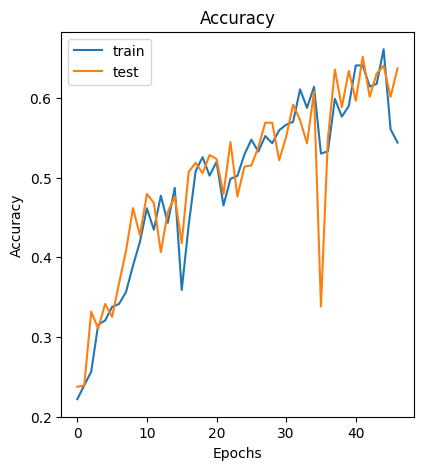

In [89]:
# Plot the training history
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

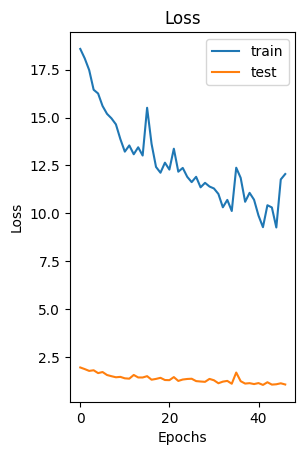

In [90]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [91]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test.reshape(X_test.shape[0], X_test.shape[1], 1), y_test)
print(f'Test accuracy: {test_acc}')

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - accuracy: 0.6472 - loss: 1.1096
Test accuracy: 0.6520324945449829


In [92]:
# Function to predict emotion
def predict_emotion(file_path):
    features = extract_features(file_path)
    features = (features - mean) / std
    prediction = model.predict(features.reshape(1, -1, 1))
    emotion_label = label_encoder.inverse_transform(prediction.argmax(axis=1))
    return emotion_label[0]

In [96]:
# Test the model with a sample file
sample_file = 'C:/Users\Dell/OneDrive/Desktop/Voice_emotion_detection/ravdess/Actor_02/03-01-08-01-02-01-02.wav'
predicted_emotion = predict_emotion(sample_file)
print(f'Predicted emotion: {predicted_emotion}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Predicted emotion: surprised
